In [24]:
!pip install datasets -q
!pip install accelerate -U -q
!pip install bitsandbytes -q
!pip install pynvml -q

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [1]:
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments, Trainer, logging
import bitsandbytes as bnb
from accelerate import Accelerator
from datasets import load_dataset
from torch.utils.data import DataLoader

In [2]:
#load instagram dataset from hugging face (takes around 5 min to load)
dataset = load_dataset('kkcosmos/instagram-images-with-captions')

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'item_id', 'image_path', 'caption'],
        num_rows: 28360
    })
    test: Dataset({
        features: ['image', 'item_id', 'image_path', 'caption'],
        num_rows: 3152
    })
})

In [3]:
#load model
model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

In [4]:
from transformers import AutoProcessor
processor = AutoProcessor.from_pretrained("microsoft/git-base")

In [5]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item["image"], text=item["caption"], padding="max_length", truncation=True, return_tensors="pt")
        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}
        return encoding

In [6]:
train_dataset = ImageCaptioningDataset(dataset['train'], processor)
test_dataset = ImageCaptioningDataset(dataset['test'],processor)

In [7]:
item = train_dataset[0]
for k,v in item.items(): print(k,v.shape)

input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [8]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16)

In [9]:
batch = next(iter(train_dataloader))
for k,v in batch.items(): print(k,v.shape)

input_ids torch.Size([16, 512])
attention_mask torch.Size([16, 512])
pixel_values torch.Size([16, 3, 224, 224])


In [10]:
processor.decode(batch["input_ids"][0])

'[CLS] selfie [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

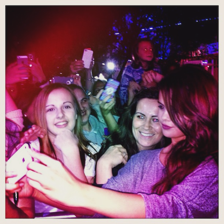

In [11]:
from PIL import Image
import numpy as np
MEAN = np.array([123.675, 116.280, 103.530]) / 255
STD = np.array([58.395, 57.120, 57.375]) / 255
unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

Compute initial loss on batch

In [12]:
outputs = model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"], pixel_values=batch["pixel_values"], labels=batch["input_ids"])
outputs.loss

tensor(12.2061, grad_fn=<NllLossBackward0>)

In [13]:
import torch
# first run the code with attention_mask commented and after your recieve a warning for adding attention mask --> uncomment the 'attention_mask' line and run the program again
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"
accelerator = Accelerator(gradient_accumulation_steps=4)
model.to(device)
model.train()
for epoch in range(5):
    print("Epoch:", epoch)
    for idx, batch in enumerate(train_dataloader):
      with accelerator.accumulate(model):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)
        attention_mask = batch.pop("attention_mask").to(device)  # added -- attention masking    # comment and uncomment
        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss
        if idx % 10 == 0:
          print("Loss:", loss.item() , "current epoch " , epoch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

Epoch: 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 12.450407981872559 current epoch  0
Loss: 8.615266799926758 current epoch  0
Loss: 7.548579216003418 current epoch  0
Loss: 6.551339149475098 current epoch  0
Loss: 5.483758449554443 current epoch  0
Loss: 4.3856282234191895 current epoch  0
Loss: 3.2342867851257324 current epoch  0
Loss: 2.2107274532318115 current epoch  0
Loss: 1.3750399351119995 current epoch  0
Loss: 0.8027197122573853 current epoch  0
Loss: 0.5119317173957825 current epoch  0
Loss: 0.3208358585834503 current epoch  0
Loss: 0.27524664998054504 current epoch  0
Loss: 0.23263196647167206 current epoch  0
Loss: 0.26208993792533875 current epoch  0
Loss: 0.2263811081647873 current epoch  0
Loss: 0.2077096551656723 current epoch  0
Loss: 0.16669075191020966 current epoch  0
Loss: 0.1982448399066925 current epoch  0
Loss: 0.13413017988204956 current epoch  0
Loss: 0.1676401048898697 current epoch  0
Loss: 0.17604826390743256 current epoch  0
Loss: 0.14602680504322052 current epoch  0
Loss: 0.14310459792613983 curre

## Perform Inference

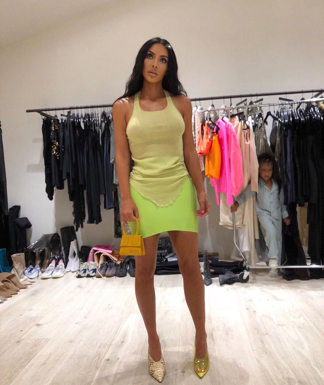

In [14]:
example = dataset['train'][3]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [22]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values
generated_ids = model.generate(pixel_values=pixel_values, max_length=150)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

i'm so excited to announce my new kkw beauty launch!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


save model

In [23]:
# saving the entire model
torch.save(model.state_dict(), "finetuned_model_IGv1")

# saving the optimizer state
torch.save(optimizer.state_dict(), "optimizer_state_IGv1")